In [5]:
import xarray as xr
import numpy as np
from xhistogram.xarray import histogram as xhist
import matplotlib.pyplot as plt
from datetime import datetime
import sys, os
sys.path.append(os.path.abspath("/work/bb1018/b380873/tropic_vis/utilities/"))
from plotting_utilities import *

### Combine all ICON trajectories into 1 file

In [ ]:
# Concatenate all of the ICON-1M trajectory files into one
basedir = '/work/bb1018/b380873/traj_output/traj_ICON_0V1M0A0R/'
new_file = xr.open_dataset( basedir + 'traj_tst00001350_p001_trim_extract_dt.nc' )
for i in np.arange(2,27):
    print(i)
    file2 = xr.open_dataset( basedir + 'traj_tst00001350_p' + traj_prefix(i) + str(i) + '_trim_extract_dt.nc' ) # ICON
    new_file = xr.concat( (new_file, file2), dim='id' )
    
display(new_file)
new_file.to_netcdf( path=basedir + 'traj_tst00001350_trim_extract_dt.nc' )

In [ ]:
# Concatenate all of the ICON-2M trajectory files into one
basedir = '/work/bb1018/b380873/traj_output/traj_ICON_0V2M0A0R/'
new_file = xr.open_dataset( basedir + 'traj_tst00000450_p001_trim_extract_dt.nc' )
for i in np.arange(2,27):
    print(i)
    file2 = xr.open_dataset( basedir + 'traj_tst00000450_p' + traj_prefix(i) + str(i) + '_trim_extract_dt.nc' ) # ICON
    new_file = xr.concat( (new_file, file2), dim='id' )
    
display(new_file)
new_file.to_netcdf( path=basedir + 'traj_tst00000450_trim_extract_dt.nc' )

### Combine all CLaMS trajectores into 1 file

In [ ]:
# Concatenate all of the CLAMS trajectory files into one
basedir = '/work/bb1018/b380873/traj_output/traj_CLAMS-Tf_0V2M0A0R/'
new_file = xr.open_dataset( basedir + 'cirrus_tst00000450_p001_trim_extract_clams_dt_iwc.nc' )
for i in np.arange(2,27):
    print(i)
    file2 = xr.open_dataset( basedir + 'cirrus_tst00000450_p' + traj_prefix(i) + str(i) + '_trim_extract_clams_dt_iwc.nc' ) # CLaMS
    new_file = xr.concat( (new_file, file2), dim='NPARTS' )
    
#display(new_file)
new_file.to_netcdf( path=basedir + 'cirrus_tst00000450_trim_extract_clams_dt_iwc.nc' )

### cdo commands to adjust the ICON nc variable names and contents

In [ ]:
cdo chname,t,T,qni,Ni ICON_file.nc ICON_file2.nc
cdo merge -expr,'psati=exp(9.550426-5723.265/T+3.53068*log(T)-0.00728332*T)' ICON_file2.nc ICON_file2.nc ICON_file3.nc
cdo merge -expr,'RHI=qv*100/0.622/psati*(p-psati)' ICON_file3.nc ICON_fil3.nc ICON_file4.nc

### cdo commands to adjust the CLaMS nc variables names and contents

In [ ]:
ncrename -d NPARTS,id CLAMS_file.nc CLAMS_file2.nc
cdo expr,qi=IWC_het+IWC_hom+IWC_pre -expr,Ni=ICN_pre+ICN_het+ICN_hom -chname,rho,RHO CLAMS_file2.nc CLAMS_file3.nc
cdo settaxis,2017-08-06,09:00:00,24sec CLAMS_file3.nc CLAMS_file4.nc

### Load all trajectories for 5 simulations from 5 files
Initiate the binning for different variables here as well.

In [6]:
# These thresholds are used throughout. Values below are considered negligible.
qi_threshold = 10**(-8)
Ni_threshold = 10**(-8)
RHi_threshold = 0

In [31]:
basedir = '/work/bb1018/b380873/traj_output/'
fichiers = [ 'CLAMS-Tf_0V1M0A0R_tst00001350_trim_extract_dt_iwc.nc', 'ICON_0V1M0A0R_tst00001350_trim_extract_dt.nc',
             'CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc', 'ICON_0V2M0A0R_tst00000450_trim_extract_dt.nc',
             'CLAMS_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc']

# Logarithmic IWC bins in ppmv, as well as their centerpoints
qi_bins = np.logspace( -5, 3.5, 50 )
qi_bins_c = ( qi_bins[1:] + qi_bins[:-1] )/2.

# Logarithmic Ni bins in cm-3, as well as their centerpoints
Ni_bins = np.logspace( -4, 5.5, 50 )
Ni_bins_c = ( Ni_bins[1:] + Ni_bins[:-1] )/2.

# Linear T bins in K
T_bins = np.linspace( 190, 240, 50 )
T_bins_c = ( T_bins[1:] + T_bins[:-1] )/2.

# Linear RHi bins in %
RHi_bins = np.linspace( 60, 120, 50 )
RHi_bins_c = ( RHi_bins[1:] + RHi_bins[:-1] )/2.

# Flight 7 track times
time0 = datetime(2017, 8, 8, 6, 20)
timef = datetime(2017, 8, 8, 6, 48)

### Create a generically structured dataset to store histogram values and copy it 5 times

In [8]:
# Initially all the datasets contain the same variables so we can create a generic dataset...
ds_generic = xr.Dataset( 
    data_vars=dict(  qih=(['qi_bin'], np.zeros(qi_bins_c.shape)),
                     Nih=(['Ni_bin'], np.zeros(Ni_bins_c.shape)),
                     Th=(['T_bin'], np.zeros(T_bins_c.shape)),
                     qih_outflow=(['qi_bin'], np.zeros(qi_bins_c.shape)),
                     Nih_outflow=(['Ni_bin'], np.zeros(Ni_bins_c.shape)),
                     qih_insitu=(['qi_bin'], np.zeros(qi_bins_c.shape)),
                     Nih_insitu=(['Ni_bin'], np.zeros(Ni_bins_c.shape)),
                     qih_flight=(['qi_bin'], np.zeros(qi_bins_c.shape)),
                     Nih_flight=(['Ni_bin'], np.zeros(Ni_bins_c.shape)),
                     RHih=(['RHi_bin'], np.zeros(RHi_bins_c.shape)) ),
    coords=dict(  qi_bin=(['qi_bin'], qi_bins_c),
                  Ni_bin=(['Ni_bin'], Ni_bins_c),
                  T_bin=(['T_bin'], T_bins_c),
                  RHi_bin=(['RHi_bin'], RHi_bins_c) ) )

# ... and then copy it 5 times.
datasets = [ ds_generic, ds_generic.copy(), ds_generic.copy(), ds_generic.copy(), ds_generic.copy() ]
del ds_generic

## Different 'flavors' of qi and Ni histograms calculated and mean / median qi / Ni printed

In [9]:
RHi_1M = xr.open_dataset( basedir + fichiers[0] )['RHI']
RHi_2M = xr.open_dataset( basedir + fichiers[2] )['RHI']
RHi_fi = [ RHi_1M, RHi_1M, RHi_2M, RHi_2M, RHi_2M ]

In [11]:
%%time
# Save the qih_* values in the Datasets above
for f, d, r in zip(fichiers, datasets, RHi_fi):
    print(f)
    fi = xr.open_dataset( basedir + f )
    
    # Convert kg kg-1 to ppmv
    qi = fi['qi'] * 10**6
    T = fi['T']
    time = fi['time']

    # Filter for non-negligible qi (or now CLaMS RHi) values; side-note: large peak in ICON qi at 10**(-10)
    #qi = qi.where( qi > qi_threshold )
    qi = qi.where( (r > RHi_threshold ) & (qi > qi_threshold) )
    qi_outflow = qi.where( (T >= 210) & (T <= 237) )
    qi_insitu = qi.where( (T < 210) )
    qi_flight = qi.sel( time=slice(time0, timef) )
    print(np.nanmean(qi),np.nanmedian(qi))
    print(np.nanmean(qi_outflow),np.nanmedian(qi_outflow))
    print(np.nanmean(qi_insitu),np.nanmedian(qi_insitu))
    print(np.nanmean(qi_flight),np.nanmedian(qi_flight))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

    # Weight by the total number of non-nan values
    wgts = 1*xr.apply_ufunc( np.isfinite, qi )
    print( np.array(wgts).flatten().sum() )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qi, dim=['time','id'], block_size=100, weights=wgts, bins=[qi_bins] )
    d['qih'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, qi_outflow )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qi_outflow, dim=['time','id'], block_size=100, weights=wgts, bins=[qi_bins] )
    d['qih_outflow'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, qi_insitu )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qi_insitu, dim=['time','id'], block_size=100, weights=wgts, bins=[qi_bins] )
    d['qih_insitu'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, qi_flight )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qi_flight, dim=['time','id'], block_size=100, weights=wgts, bins=[qi_bins] )
    d['qih_flight'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, T )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( T, dim=['time','id'], block_size=100, weights=wgts, bins=[T_bins] )
    d['Th'] = h
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

ICON_0V1M0A0R_tst00001350_trim_extract_dt.nc
12.815873928466225 2.5137671855191
13.007832929501554 3.348838163219625
0.038483708970089965 0.0013482108207618637
12.62016655881588 3.799135129156639
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
100.00000000000065
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc
50.06317234368266 10.706458851927891
47.5484617923896 10.345172086090315
46.21445722493585 7.389635356958024
10.213049518029775 1.4763724038857617
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
99.99999999999967
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ICON_0V2M0A0R_tst00000450_trim_extract_dt.nc
17.561320065527454 0.07313830963084911
24.02025057628062 1.4000875694364368
0.4425938414312553 0.00041556737218062523
4.247955796477289 0.05443714989894488
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
99.99999999999865
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CLAMS_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc
49.51223650988464 9.44597

In [13]:
%%time
# Save the Nih_* values in the Datasets above.
for f, d, r in zip(fichiers, datasets, RHi_fi):
    print(f)
    fi = xr.open_dataset( basedir + f )
    
    # Convert kg-1 to L-1
    rho = fi['rho']
    Ni = fi['Ni'] * rho  / 1000.
    Ni.name = fi['Ni'].name
    T = fi['T']
    time = fi['time']
    
    # Filter for non-negligible values
    Ni = Ni.where( (r > RHi_threshold ) & (Ni > Ni_threshold) )
    Ni_outflow = Ni.where( (T >= 210) & (T <= 237) )
    Ni_insitu = Ni.where( (T < 210) )
    Ni_flight = Ni.sel( time=slice(time0, timef) )
    print(np.nanmean(Ni),np.nanmedian(Ni))
    print(np.nanmean(Ni_outflow),np.nanmedian(Ni_outflow))
    print(np.nanmean(Ni_insitu),np.nanmedian(Ni_insitu))
    print(np.nanmean(Ni_flight),np.nanmedian(Ni_flight))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

    # Weight by the total number of non-nan values
    wgts = 1*xr.apply_ufunc( np.isfinite, Ni )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( Ni, dim=['time','id'], block_size=100, weights=wgts, bins=[Ni_bins] )
    d['Nih'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, Ni_outflow )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( Ni_outflow, dim=['time','id'], block_size=100, weights=wgts, bins=[Ni_bins] )
    d['Nih_outflow'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, Ni_insitu )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( Ni_insitu, dim=['time','id'], block_size=100, weights=wgts, bins=[Ni_bins] )
    d['Nih_insitu'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, Ni_flight )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( Ni_flight, dim=['time','id'], block_size=100, weights=wgts, bins=[Ni_bins] )
    d['Nih_flight'] = h

CLAMS-Tf_0V1M0A0R_tst00001350_trim_extract_dt_iwc.nc
553.1730400551742 2.798247473863036
581.6097000256811 2.413705583311037
29646.653536018614 87.01144197681259
1820.5885892749707 5.521633161654374
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ICON_0V1M0A0R_tst00001350_trim_extract_dt.nc


<timed exec>:18: RuntimeWarning: Mean of empty slice
/pf/b/b380459/conda-envs/Nawdex-Hackathon/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


nan nan


<timed exec>:19: RuntimeWarning: Mean of empty slice


nan nan


<timed exec>:20: RuntimeWarning: Mean of empty slice


nan nan
nan nan
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


<timed exec>:21: RuntimeWarning: Mean of empty slice


CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc
690.1160244297432 17.313827897042355
662.2413196881845 16.951292591950967
3259.4839372718 125.08610696812067
337.4802397060753 2.5079464253668617
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ICON_0V2M0A0R_tst00000450_trim_extract_dt.nc
1517.2982 1.2495967
1864.8809 4.7235217
60.765667 0.014924884
57.88505 0.7324174
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CLAMS_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc
682.969369021075 12.995340823781252
656.321764168674 12.5611065435725
3116.2308763551414 58.18936472657443
365.82019084895074 1.5053118073812095
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CPU times: user 2min 39s, sys: 3min 11s, total: 5min 51s
Wall time: 33min 27s


### TE and RHI histograms calculated

In [17]:
%%time
basedir = '/work/bb1018/b380873/traj_output/'
# Save the RHIh_ values for both datasets and the TEh_* values for the CLaMS Datasets only
for f, d in zip(fichiers[1::2], datasets[1::2]):
    print(f)
    fi = xr.open_dataset( basedir + f )
    qi = fi['qi'] * 10**6
    RHi = fi['RHI'].where( qi > qi_threshold )
    
    wgts = 1*xr.apply_ufunc( np.isfinite, RHi )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( RHi, dim=['time','id'], block_size=100, weights=wgts, bins=[RHi_bins] )
    d['RHih'] = h

for f, d in zip(fichiers[::2], datasets[::2]):
    print(f)
    fi = xr.open_dataset( basedir + f )
    qi = fi['qi'] * 10**6
    TE = fi['TE'].where( qi > qi_threshold )
    RHi = fi['RHI'].where( qi > qi_threshold )

    # Weight by the total number of non-nan values
    wgts = 1*xr.apply_ufunc( np.isfinite, TE )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( TE, dim=['time','id'], block_size=100, weights=wgts, bins=[T_bins] )
    d['TEh'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, RHi )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( RHi, dim=['time','id'], block_size=100, weights=wgts, bins=[RHi_bins] )
    d['RHih'] = h

ICON_0V1M0A0R_tst00001350_trim_extract_dt.nc
ICON_0V2M0A0R_tst00000450_trim_extract_dt.nc
CLAMS-Tf_0V1M0A0R_tst00001350_trim_extract_dt_iwc.nc
CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc
CLAMS_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc
CPU times: user 1min 17s, sys: 1min 52s, total: 3min 9s
Wall time: 26min 54s


### qi-Nih-T-RHi histograms saved to nc files

In [19]:
# Save the qi and Ni histogram datasets in nc files
scratchdir = '/scratch/b/b380873/traj_pp/'
names = [ 'qih-Nih-CLAMS-Tf_0V1M0A0R2.nc', 'qih-Nih-ICON_0V1M0A0R2.nc', 
          'qih-Nih-CLAMS-Tf_0V2M0A0R2.nc', 'qih-Nih-ICON_0V2M0A0R2.nc',
          'qih-Nih-CLAMS_0V2M0A0R2.nc']
for n, d in zip(names, datasets):
    d.to_netcdf( scratchdir + n )

## Ice microphysical process histograms
These differ between CLaMS and ICON so we have to initially create two different structures.

In [4]:
# For CLaMS, we will look at the homogeneous, heterogeneous, and preexisiting qi and Ni
ds_clams = xr.Dataset( 
    data_vars=dict(  qhomih=(['qi_bin'], np.zeros(qi_bins_c.shape)),
                     Nhomih=(['Ni_bin'], np.zeros(Ni_bins_c.shape)),
                     qhetih=(['qi_bin'], np.zeros(T_bins_c.shape)),
                     Nhetih=(['Ni_bin'], np.zeros(qi_bins_c.shape)),
                     qpreih=(['qi_bin'], np.zeros(qi_bins_c.shape)),
                     Npreih=(['Ni_bin'], np.zeros(Ni_bins_c.shape)) ),
    coords=dict(  qi_bin=(['qi_bin'], qi_bins_c),
                  Ni_bin=(['Ni_bin'], Ni_bins_c) ) )

# ... and then copy it 3 times.
datasets_clams = [ ds_clams, ds_clams.copy(), ds_clams.copy() ]
del ds_clams

In [5]:
# For ICON, we will look at qi and Ni sedimentation fluxes in and out
ds_icon = xr.Dataset( 
    data_vars=dict(  qsedih=(['qi_bin'], np.zeros(qi_bins_c.shape)),
                     Nsedih=(['Ni_bin'], np.zeros(Ni_bins_c.shape)),
                     qsedoh=(['qi_bin'], np.zeros(T_bins_c.shape)),
                     Nsedoh=(['Ni_bin'], np.zeros(qi_bins_c.shape)) ),
    coords=dict(  qi_bin=(['qi_bin'], qi_bins_c),
                  Ni_bin=(['Ni_bin'], Ni_bins_c) ) )

# ... and then copy it 3 times.
datasets_icon = [ ds_icon, ds_icon.copy(), ds_icon.copy() ]
del ds_icon

In [9]:
basedir = '/work/bb1018/b380873/traj_output/'
for f, d in zip(fichiers[::2], datasets_clams):
    print(f)
    fi = xr.open_dataset( basedir + f )
    
    # Convert to ppmv / L-1 and filter for non-negligible values
    qi_hom = fi['IWC_hom'] * 10**6
    qi_hom = qi_hom.where( qi_hom > qi_threshold )
    
    qi_het = fi['IWC_het'] * 10**6
    qi_het = qi_het.where( qi_het > qi_threshold )
    
    qi_pre = fi['IWC_pre'] * 10**6
    qi_pre = qi_pre.where( qi_pre > qi_threshold )
    
    rho = fi['rho']
    Ni_hom = fi['ICN_hom'] * rho / 1000
    Ni_hom.name = fi['ICN_hom'].name
    Ni_hom = Ni_hom.where( Ni_hom > Ni_threshold )
    
    Ni_het = fi['ICN_het'] * rho / 1000
    Ni_het.name = fi['ICN_het'].name
    Ni_het = Ni_hom.where( Ni_het > Ni_threshold )
    
    Ni_pre = fi['ICN_pre'] * rho / 1000
    Ni_pre.name = fi['ICN_pre'].name
    Ni_pre = Ni_pre.where( Ni_pre > Ni_threshold )

    # Weight by the total number of non-nan values
    wgts = 1*xr.apply_ufunc( np.isfinite, qi_hom )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qi_hom, dim=['time','id'], block_size=100, weights=wgts, bins=[qi_bins] )
    d['qhomih'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, qi_het )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qi_het, dim=['time','id'], block_size=100, weights=wgts, bins=[qi_bins] )
    d['qhetih'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, qi_pre )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qi_pre, dim=['time','id'], block_size=100, weights=wgts, bins=[qi_bins] )
    d['qpreih'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, Ni_hom )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( Ni_hom, dim=['time','id'], block_size=100, weights=wgts, bins=[Ni_bins] )
    d['Nhomih'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, Ni_het )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( Ni_het, dim=['time','id'], block_size=100, weights=wgts, bins=[Ni_bins] )
    d['Nhetih'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, Ni_pre )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( Ni_pre, dim=['time','id'], block_size=100, weights=wgts, bins=[Ni_bins] )
    d['Npreih'] = h

CLAMS-Tf_0V1M0A0R_tst00001350_trim_extract_dt_iwc.nc
CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc
CLAMS_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc


In [7]:
%%time
basedir = '/work/bb1018/b380873/traj_output/'
# Save the <process>h_ values for both datasets, ICON first
for f, d in zip(fichiers[1::2], datasets_icon):
    print(f)
    fi = xr.open_dataset( basedir + f )
    
    # Convert to ppmv and filter for non-negligible values
    # We want the magnitude of these sedimentation values so multiply by -1.
    qsedi = -1*fi['qsedi'] * 10**6
    qsedi = qsedi.where( qsedi > qi_threshold )
    qsedo = -1*fi['qsedo'] * 10**6
    qsedo = qsedo.where( qsedo > qi_threshold )
    
    # As above but converting to L-1
    rho = fi['rho']
    qnsedi = fi['qnsedi'] * rho / 1000.
    qnsedi.name = fi['qnsedi'].name
    qnsedi = -1*qnsedi.where( qnsedi > Ni_threshold )               
    qnsedo = fi['qnsedo'] * rho / 1000.
    qnsedo.name = fi['qnsedo'].name
    qnsedo = -1*qnsedi.where( qnsedo > Ni_threshold )    
    
    wgts = 1*xr.apply_ufunc( np.isfinite, qsedi )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qsedi, dim=['time','id'], block_size=100, weights=wgts, bins=[qi_bins] )
    d['qsedih'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, qsedo )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qsedo, dim=['time','id'], block_size=100, weights=wgts, bins=[qi_bins] )
    d['qsedoh'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, qnsedi )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qnsedi, dim=['time','id'], block_size=100, weights=wgts, bins=[Ni_bins] )
    d['qnsedih'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, qnsedo )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qnsedo, dim=['time','id'], block_size=100, weights=wgts, bins=[Ni_bins] )
    d['qnsedoh'] = h

ICON_0V1M0A0R_tst00001350_trim_extract_dt.nc
ICON_0V2M0A0R_tst00000450_trim_extract_dt.nc
CPU times: user 1min 21s, sys: 1min 53s, total: 3min 14s
Wall time: 18min 18s


In [10]:
scratchdir = '/scratch/b/b380873/traj_pp/'
names = [ 'het-hom-pre-CLAMS-Tf_0V1M0A0R.nc', 'qsed-ICON_0V1M0A0R.nc', 
          'het-hom-pre-CLAMS-Tf_0V2M0A0R.nc', 'qsed-ICON_0V2M0A0R.nc',
          'het-hom-pre-CLAMS_0V2M0A0R.nc']
datasets = [ datasets_clams[0], datasets_icon[0], datasets_clams[1],
             datasets_icon[1], datasets_clams[2] ]
for n, d in zip(names, datasets):
    d.to_netcdf( scratchdir + n )

## Two-dimensional histograms - qi, Ni versus T, RHi

In [32]:
# Reduce the number of qi and Ni bins relative to the 1D histograms

# Logarithmic IWC bins in ppmv, as well as their centerpoints
qi_bins = np.logspace( -5, 3.5, 25 )
qi_bins_c = ( qi_bins[1:] + qi_bins[:-1] )/2.

# Logarithmic Ni bins in cm-3, as well as their centerpoints
Ni_bins = np.logspace( -4, 5.5, 25 )
Ni_bins_c = ( Ni_bins[1:] + Ni_bins[:-1] )/2.

In [52]:
# Initially all the datasets contain the same variables so we can create a generic dataset...
qs = qi_bins_c.shape[0]
ts = T_bins_c.shape[0]
ns = Ni_bins_c.shape[0]
rs = RHi_bins_c.shape[0]

ds_generic = xr.Dataset( 
    data_vars=dict(  qiTh=(['qi_bin','T_bin'], np.zeros(( qs, ts )) ),
                     NiTh=(['Ni_bin','T_bin'], np.zeros(( ns, ts )) ),
                     qiRHih=(['qi_bin','RHi_bin'], np.zeros(( qs, rs )) ),
                     NiRHih=(['Ni_bin','RHi_bin'], np.zeros(( ns, rs )) ),
                     qiTh_outflow=(['qi_bin','T_bin'], np.zeros(( qs, ts )) ),
                     NiTh_outflow=(['Ni_bin','T_bin'], np.zeros(( ns, ts )) ),
                     qiRHih_outflow=(['qi_bin','RHi_bin'], np.zeros(( qs, rs )) ),
                     NiRHih_outflow=(['Ni_bin','RHi_bin'], np.zeros(( ns, rs )) ),
                     qiTh_insitu=(['qi_bin','T_bin'], np.zeros(( qs, ts )) ),
                     NiTh_insitu=(['Ni_bin','T_bin'], np.zeros(( ns, ts )) ),
                     qiRHih_insitu=(['qi_bin','RHi_bin'], np.zeros(( qs, rs )) ),
                     NiRHih_insitu=(['Ni_bin','RHi_bin'], np.zeros(( ns, rs )) ),
                     qiTh_flight=(['qi_bin','T_bin'], np.zeros(( qs, ts )) ),
                     NiTh_flight=(['Ni_bin','T_bin'], np.zeros(( ns, ts )) ),
                     qiRHih_flight=(['qi_bin','RHi_bin'], np.zeros(( qs, rs )) ),
                     NiRHih_flight=(['Ni_bin','RHi_bin'], np.zeros(( ns, rs )) ),),
    coords=dict(  qi_bin=(['qi_bin'], qi_bins_c),
                  Ni_bin=(['Ni_bin'], Ni_bins_c),
                  T_bin=(['T_bin'], T_bins_c),
                  RHi_bin=(['RHi_bin'], RHi_bins_c)) )

# ... and then copy it 5 times.
datasets = [ ds_generic, ds_generic.copy(), ds_generic.copy(), ds_generic.copy(), ds_generic.copy() ]
del ds_generic

In [54]:
for f, d, r in zip(fichiers, datasets, RHi_fi):
    print(f)
    fi = xr.open_dataset( basedir + f )
    
    # Convert kg kg-1 to ppmv
    qi = fi['qi'] * 10**6
    T = fi['T']
    time = fi['time']

    # Filter for non-negligible qi (or now CLaMS RHi) values; side-note: large peak in ICON qi at 10**(-10)
    #qi = qi.where( qi > qi_threshold )
    qi = qi.where( (r > RHi_threshold ) & (qi > qi_threshold) )
    T = T.where( (r > RHi_threshold ) & (qi > qi_threshold) )
    
    qi_outflow = qi.where( (T >= 210) & (T <= 237) )
    T_outflow = T.where( (T >= 210) & (T <= 237) )
    
    qi_insitu = qi.where( (T < 210) )
    T_insitu = T.where( (T < 210) )
    
    qi_flight = qi.sel( time=slice(time0, timef) )
    T_flight = T.sel( time=slice(time0, timef) )

    # Weight by the total number of non-nan values
    wgts = 1*xr.apply_ufunc( np.isfinite, qi )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qi, T, block_size=100, bins=[qi_bins, T_bins], weights=wgts )
    d['qiTh'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, qi_outflow )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qi_outflow, T_outflow, block_size=100, bins=[qi_bins, T_bins], weights=wgts )
    d['qiTh_outflow'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, qi_insitu )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qi_insitu, T_insitu, block_size=100, bins=[qi_bins, T_bins], weights=wgts )
    d['qiTh_insitu'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, qi_flight )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qi_flight, T_flight, block_size=100, bins=[qi_bins, T_bins], weights=wgts )
    d['qiTh_flight'] = h
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

CLAMS-Tf_0V1M0A0R_tst00001350_trim_extract_dt_iwc.nc
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ICON_0V1M0A0R_tst00001350_trim_extract_dt.nc
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ICON_0V2M0A0R_tst00000450_trim_extract_dt.nc
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CLAMS_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [57]:
for f, d, r in zip(fichiers, datasets, RHi_fi):
    print(f)
    fi = xr.open_dataset( basedir + f )
    
    # Convert kg kg-1 to ppmv
    qi = fi['qi'] * 10**6
    RHI = fi['RHI']
    T = fi['T']
    time = fi['time']

    # Filter for non-negligible qi (or now CLaMS RHi) values; side-note: large peak in ICON qi at 10**(-10)
    #qi = qi.where( qi > qi_threshold )
    qi = qi.where( (r > RHi_threshold ) & (qi > qi_threshold) )
    RHI = RHI.where( (r > RHi_threshold ) & (qi > qi_threshold) )
    
    qi_outflow = qi.where( (T >= 210) & (T <= 237) )
    RHI_outflow = RHI.where( (T >= 210) & (T <= 237) )
    
    qi_insitu = qi.where( (T < 210) )
    RHI_insitu = RHI.where( (T < 210) )
    
    qi_flight = qi.sel( time=slice(time0, timef) )
    RHI_flight = RHI.sel( time=slice(time0, timef) )

    # Weight by the total number of non-nan values
    wgts = 1*xr.apply_ufunc( np.isfinite, qi )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qi, RHI, block_size=100, bins=[qi_bins, RHi_bins], weights=wgts )
    d['qiRHih'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, qi_outflow )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qi_outflow, RHI_outflow, block_size=100, bins=[qi_bins, RHi_bins], weights=wgts )
    d['qiRHih_outflow'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, qi_insitu )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qi_insitu, RHI_insitu, block_size=100, bins=[qi_bins, RHi_bins], weights=wgts )
    d['qiRHih_insitu'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, qi_flight )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( qi_flight, RHI_flight, block_size=100, bins=[qi_bins, RHi_bins], weights=wgts )
    d['qiRHih_flight'] = h
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

CLAMS-Tf_0V1M0A0R_tst00001350_trim_extract_dt_iwc.nc
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ICON_0V1M0A0R_tst00001350_trim_extract_dt.nc
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ICON_0V2M0A0R_tst00000450_trim_extract_dt.nc
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CLAMS_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [56]:
%%time
# Save the Nih_* values in the Datasets above.
for f, d, r in zip(fichiers, datasets, RHi_fi):
    print(f)
    fi = xr.open_dataset( basedir + f )
    
    # Convert kg-1 to L-1
    rho = fi['rho']
    Ni = fi['Ni'] * rho  / 1000.
    Ni.name = fi['Ni'].name
    T = fi['T']
    time = fi['time']
    
    # Filter for non-negligible values
    Ni = Ni.where( (r > RHi_threshold ) & (Ni > Ni_threshold) )
    T = T.where( (r > RHi_threshold ) & (Ni > Ni_threshold) )
    
    Ni_outflow = Ni.where( (T >= 210) & (T <= 237) )
    T_outflow = T.where( (T >= 210) & (T <= 237) )
    
    Ni_insitu = Ni.where( (T < 210) )
    T_insitu = T.where( (T < 210) )
    
    Ni_flight = Ni.sel( time=slice(time0, timef) )
    T_flight = T.sel( time=slice(time0, timef) )

    # Weight by the total number of non-nan values
    wgts = 1*xr.apply_ufunc( np.isfinite, Ni )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( Ni, T, block_size=100, weights=wgts, bins=[Ni_bins,T_bins] )
    d['NiTh'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, Ni_outflow )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( Ni_outflow, T_outflow, block_size=100, weights=wgts, bins=[Ni_bins,T_bins] )
    d['NiTh_outflow'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, Ni_insitu )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( Ni_insitu, T_insitu, block_size=100, weights=wgts, bins=[Ni_bins,T_bins] )
    d['NiTh_insitu'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, Ni_flight )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( Ni_flight, T_flight, block_size=100, weights=wgts, bins=[Ni_bins,T_bins] )
    d['NiTh_flight'] = h

CLAMS-Tf_0V1M0A0R_tst00001350_trim_extract_dt_iwc.nc
ICON_0V1M0A0R_tst00001350_trim_extract_dt.nc
CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc
ICON_0V2M0A0R_tst00000450_trim_extract_dt.nc
CLAMS_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc
CPU times: user 3min 4s, sys: 3min 21s, total: 6min 25s
Wall time: 33min 41s


In [ ]:
%%time
# Save the Nih_* values in the Datasets above.
for f, d, r in zip(fichiers, datasets, RHi_fi):
    print(f)
    fi = xr.open_dataset( basedir + f )
    
    # Convert kg-1 to L-1
    rho = fi['rho']
    Ni = fi['Ni'] * rho  / 1000.
    Ni.name = fi['Ni'].name
    T = fi['T']
    RHI = fi['RHI']
    time = fi['time']
    
    # Filter for non-negligible values
    Ni = Ni.where( (r > RHi_threshold ) & (Ni > Ni_threshold) )
    RHI = RHI.where( (r > RHi_threshold ) & (Ni > Ni_threshold) )
    
    Ni_outflow = Ni.where( (T >= 210) & (T <= 237) )
    RHI_outflow = RHI.where( (T >= 210) & (T <= 237) )
    
    Ni_insitu = Ni.where( (T < 210) )
    RHI_insitu = RHI.where( (T < 210) )
    
    Ni_flight = Ni.sel( time=slice(time0, timef) )
    RHI_flight = RHI.sel( time=slice(time0, timef) )

    # Weight by the total number of non-nan values
    wgts = 1*xr.apply_ufunc( np.isfinite, Ni )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( Ni, RHI, block_size=100, weights=wgts, bins=[Ni_bins,RHi_bins] )
    d['NiRHih'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, Ni_outflow )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( Ni_outflow, RHI_outflow, block_size=100, weights=wgts, bins=[Ni_bins,RHi_bins] )
    d['NiRHih_outflow'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, Ni_insitu )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( Ni_insitu, RHI_insitu, block_size=100, weights=wgts, bins=[Ni_bins,RHi_bins] )
    d['NiRHih_insitu'] = h
    
    wgts = 1*xr.apply_ufunc( np.isfinite, Ni_flight )
    wgts = wgts / wgts.sum( dim=['time','id'] ) * 100.
    h = xhist( Ni_flight, RHI_flight, block_size=100, weights=wgts, bins=[Ni_bins,RHi_bins] )
    d['NiRHih_flight'] = h

CLAMS-Tf_0V1M0A0R_tst00001350_trim_extract_dt_iwc.nc
ICON_0V1M0A0R_tst00001350_trim_extract_dt.nc
CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc
ICON_0V2M0A0R_tst00000450_trim_extract_dt.nc
CLAMS_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc


In [ ]:
scratchdir = '/scratch/b/b380873/traj_pp/'
names = [ 'qiNi-TRHi-2Dh-CLAMS-Tf_0V1M0A0R.nc', 'qiNi-TRHi-2Dh-ICON_0V1M0A0R.nc', 
          'qiNi-TRHi-2Dh-CLAMS-Tf_0V2M0A0R.nc', 'qiNi-TRHi-2Dh-ICON_0V2M0A0R.nc',
          'qiNi-TRHi-2Dh-CLAMS_0V2M0A0R.nc']
datasets = [ datasets_clams[0], datasets_icon[0], datasets_clams[1],
             datasets_icon[1], datasets_clams[2] ]
for n, d in zip(names, datasets):
    d.to_netcdf( scratchdir + n )

In [53]:
fi = xr.open_dataset( basedir + fichiers[0] )
qi = fi['qi'] * 10**6
T = fi['T']

# Filter for non-negligible values
qi = qi.where( qi > qi_threshold )
T = T.where( qi > qi_threshold )

qi_wgts = 1*xr.apply_ufunc( np.isfinite, qi )
qi_wgts = qi_wgts / qi_wgts.sum( dim=['time','id'] ) * 100.

h = xhist( qi, T, block_size=100, bins=[qi_bins, T_bins], weights=qi_wgts )
datasets[0]['qiTh'] = h


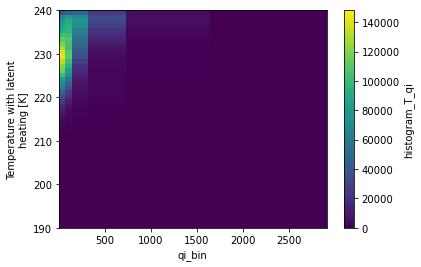

In [45]:
h.plot()

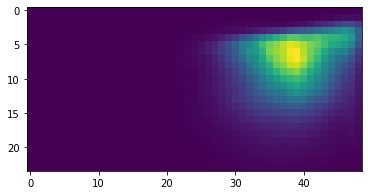

In [51]:
plt.imshow( np.flipud(h1) )